# CS5014 - Data Science

## Final Project

---

**Student Name:** Michael Nolan

**Student Number:** 18200079

**Student Email:** 18200079@studentmail.ul.ie

---

## Imports

In [1]:
from __future__ import division, print_function
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import cvxopt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

## SVM Class

- SVM class provided by Alessio which is from MLFromScratch.

_N.B.: mlfromscratch needs to be installed. Instructions can be found at the link below._

In [2]:
# mlfromscratch install instructions can be found here:
# https://github.com/eriklindernoren/ML-From-Scratch#installation

# Pulled needed kernels from MLFromScratch repo
def linear_kernel(**kwargs):
    def f(x1, x2):
        return np.inner(x1, x2)
    return f

def rbf_kernel(gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    return f

# SVM Class
class SupportVectorMachine(object):
    """The Support Vector Machine classifier.
    Uses cvxopt to solve the quadratic optimization problem.

    Parameters:
    -----------
    C: float
        Penalty term.
    kernel: function
        Kernel function. Can be either polynomial, rbf or linear.
    power: int
        The degree of the polynomial kernel. Will be ignored by the other
        kernel functions.
    gamma: float
        Used in the rbf kernel function.
    coef: float
        Bias term used in the polynomial kernel function.
    """
    def __init__(self, C=1, kernel=rbf_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y, Z=None):
        n_samples, n_features = np.shape(X)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])
                
        # Define the quadratic optimization problem
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')
        
        # P, G and h will be defined based on constraints
        G_max = np.identity(n_samples) * -1
        G_min = np.identity(n_samples)
        
        h_max = cvxopt.matrix(np.zeros(n_samples))
        h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
        
        if Z is not None:
            Z_norm = Z - np.mean(Z)
            fair_const = (1 / n_samples) * (np.dot(Z_norm, y.T) * kernel_matrix)

#             P = 2 * cvxopt.matrix(np.outer(y, y) * kernel_matrix + np.outer(y, y) * np.eye(n_samples), tc='d')
            P = cvxopt.matrix(2 * ((kernel_matrix + (1/self.C) * (np.eye(n_samples))) * (y.dot(y.T))), tc='d')
            
            G_1 = cvxopt.matrix(fair_const, tc='d')
            G_2 = cvxopt.matrix(-fair_const, tc='d')
            G = cvxopt.matrix(np.vstack((G_max, G_min, G_1, G_2)), tc='d')
            
            h_1 = cvxopt.matrix(np.ones(n_samples) * self.C, tc='d')
            h_2 = cvxopt.matrix((np.ones(n_samples) * self.C) * -1, tc='d')
            h = cvxopt.matrix(np.vstack((h_max, h_min, h_1, h_2)), tc='d')
        else:
            P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
            G = cvxopt.matrix(np.vstack((G_max, G_min)), tc='d')
            h = cvxopt.matrix(np.vstack((h_max, h_min)), tc='d')

        cvxopt.solvers.options['show_progress'] = False # Hide cvxopt output
        cvxopt.solvers.options['abstol'] = 1e-10
        cvxopt.solvers.options['reltol'] = 1e-10
        cvxopt.solvers.options['feastol'] = 1e-10
        
        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])

        # Extract support vectors
        # Get indexes of non-zero lagr. multipiers
        idx = lagr_mult > 1e-7
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        # Support vector indices
        self.support = idx
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        # Get the corresponding labels
        self.support_vector_labels = y[idx]
        
        #coef
        self.w = ((y * lagr_mult).T @ X)
        self.b = y[idx] - np.dot(X[idx], self.w)

        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

## Compute P-rule

In [3]:
def compute_p_rule(x_control, predictions):

    """ Compute the p-rule based on Doctrine of disparate impact """

    non_prot_all = sum(x_control == 1.0) # non-protected group
    prot_all = sum(x_control == 0.0) # protected group
    non_prot_pos = sum(predictions[x_control == 1.0] == 1.0) # non_protected in positive class
    prot_pos = sum(predictions[x_control == 0.0] == 1.0) # protected in positive class
    frac_non_prot_pos = float(non_prot_pos) / float(non_prot_all)
    frac_prot_pos = float(prot_pos) / float(prot_all)
    p_rule = (frac_prot_pos / frac_non_prot_pos) * 100.0
    print
    print ("Total data points: %d" % (len(x_control)))
    print ("# non-protected examples: %d" % (non_prot_all))
    print ("# protected examples: %d" % (prot_all))
    print ("Non-protected in positive class: %d (%0.0f%%)" % (non_prot_pos, non_prot_pos * 100.0 / non_prot_all))
    print ("Protected in positive class: %d (%0.0f%%)" % (prot_pos, prot_pos * 100.0 / prot_all))
    print ("P-rule is: %0.0f%%" % ( p_rule ))
    return p_rule

## Synthetic Data

Create synthetic data used in the paper. This generation code was found in the repo associated with the paper. Some slight modifications were made to make it execute without error due to different Python versions. Also, instead of the method returning a dictionary for `x_control`, it has been changed to kist return the matrix of values.

In [4]:
import math
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data

SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def generate_synthetic_data(plot_data=False):
    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    n_samples = 1000 # generate these many data points per class
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = range(0,n_samples*2)
    shuffle(list(perm))
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if (r < p1).any(): # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]

        X_s_0 = x_draw[x_control_draw == 0.0]
        X_s_1 = x_draw[x_control_draw == 1.0]
        y_s_0 = y_draw[x_control_draw == 0.0]
        y_s_1 = y_draw[x_control_draw == 1.0]
        plt.figure(figsize=(10, 7))
        plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='blue', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
        plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
        plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='blue', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
        plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")
        plt.show()
    
    return X,y,x_control

In [5]:
# Generate the synthetic data.
# This data also needs to be shuffled before it is split for train / test
X_syn, y_syn, x_control_syn = generate_synthetic_data(plot_data=False)

# Shuffle
indices = np.arange(X_syn.shape[0])
np.random.shuffle(indices)

X_syn = X_syn[indices]
y_syn = y_syn[indices]
x_control_syn = x_control_syn[indices]

In [6]:
x_min = np.min(X_syn[:, 0]) - 3
x_max = np.max(X_syn[:, 0]) + 3
xfit = np.linspace(x_min, x_max)

def plot_descision_boundary(X, y, w, b, support_vectors=None):
#     x_min = np.min(X[:, 0]) - 3
#     x_max = np.max(X[:, 0]) + 3
#     xfit = np.linspace(x_min, x_max)
    plt.figure(figsize=(12, 8))
    plt.scatter(X[y != 1][:, 0], X[y != 1][:, 1], c='b', s=50, marker='o', cmap='autumn', label='y = -1')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='g', s=50, marker='o', cmap='autumn', label='y =  1')
    if support_vectors is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=50, color='black', marker='o', facecolors='none', edgecolors='k', label='Support Vectors')
    plt.plot(xfit, (-w[0] * xfit-b[0])/w[1], '-k', label='Un-fair Decision Boundary')
    plt.xlim(x_min, x_max)
    plt.ylim(np.min(X[:, 1]) - 3, np.max(X[:, 1]) + 3)
    plt.legend()

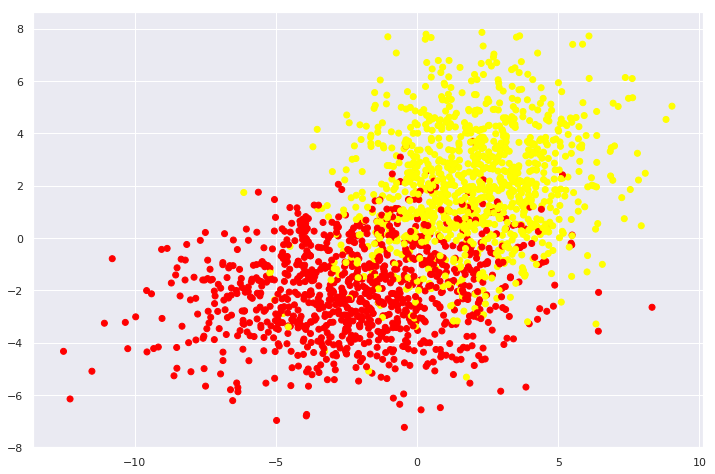

In [7]:
# Plot the full dataset
plt.figure(figsize=(12, 8))
plt.scatter(X_syn[:, 0], X_syn[:, 1], c=y_syn, cmap='autumn')
_ = plt.show()

In [8]:
# Custom train_test_split due to the fact that we need to shuffle the `Z` or `X_control` matrix too.
split_size = int(X_syn.shape[0] * .6)

X_train_syn, X_test_syn = X_syn[0:split_size], X_syn[split_size:]
y_train_syn, y_test_syn = y_syn[0:split_size], y_syn[split_size:]
Z_train_syn, Z_test_syn = x_control_syn[0:split_size], x_control_syn[split_size:]

## Un-fair / Normal SVM

In [9]:
# Unfair
svm_syn = SupportVectorMachine(C=1, kernel=linear_kernel)
svm_syn.fit(X_train_syn, y_train_syn)
y_pred_syn = svm_syn.predict(X_test_syn)

accuracy_score(y_test_syn, y_pred_syn)

0.875

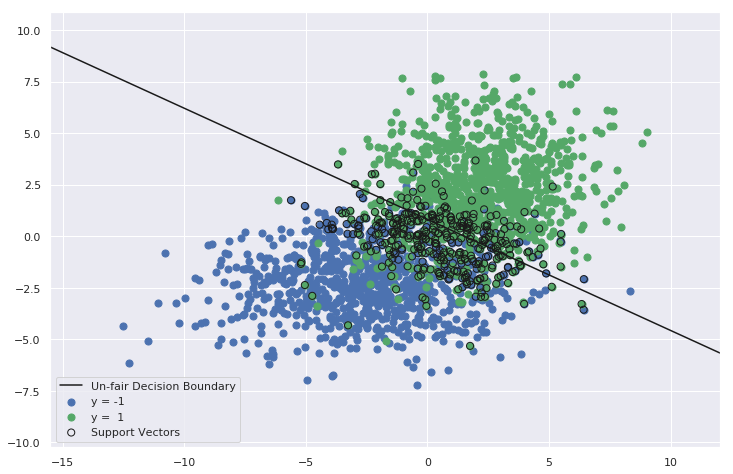

In [10]:
plot_descision_boundary(X_syn, y_syn, svm_syn.w, svm_syn.b, support_vectors=svm_syn.support_vectors)

In [11]:
compute_p_rule(Z_test_syn, y_pred_syn)

Total data points: 800
# non-protected examples: 352
# protected examples: 448
Non-protected in positive class: 223 (63%)
Protected in positive class: 116 (26%)
P-rule is: 41%


40.87123638693146

## Fair SVM

In [12]:
# Fair
fair_svm_syn = SupportVectorMachine(C=0.1, kernel=linear_kernel)
fair_svm_syn.fit(X_train_syn, y_train_syn, Z_train_syn)
y_pred_syn_fair = svm_syn.predict(X_test_syn)

accuracy_score(y_test_syn, y_pred_syn_fair)

0.875

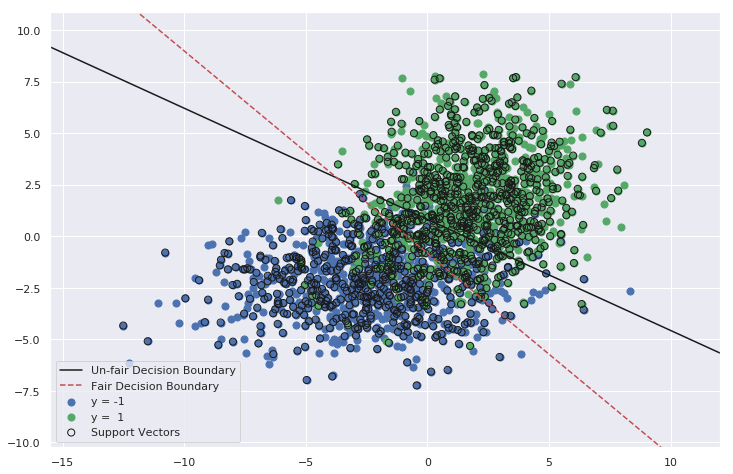

In [13]:
plot_descision_boundary(X_syn, y_syn, svm_syn.w, svm_syn.b, support_vectors=fair_svm_syn.support_vectors)
plt.plot(xfit, (-fair_svm_syn.w[0] * xfit-fair_svm_syn.b[0])/fair_svm_syn.w[1], '--r', label='Fair Decision Boundary')
_ = plt.legend()

In [14]:
compute_p_rule(Z_test_syn, y_pred_syn_fair)

Total data points: 800
# non-protected examples: 352
# protected examples: 448
Non-protected in positive class: 223 (63%)
Protected in positive class: 116 (26%)
P-rule is: 41%


40.87123638693146

## SVM sklearn

In [15]:
# sklearn test to compare accuracy of un-fair SVM
from sklearn.svm import SVC
sk_svc_syn = SVC(gamma='auto', kernel='linear')
sk_svc_syn.fit(X_train_syn, y_train_syn)
y_pred_svc_syn = sk_svc_syn.predict(X_test_syn)

accuracy_score(y_test_syn, y_pred_svc_syn)

0.87625

In [16]:
compute_p_rule(Z_test_syn, y_pred_svc_syn)

Total data points: 800
# non-protected examples: 352
# protected examples: 448
Non-protected in positive class: 242 (69%)
Protected in positive class: 138 (31%)
P-rule is: 45%


44.80519480519481